# LSTM et Attention

Attention layer is getting a lot of attention in recent years. It was originally proposed to alleviate the long-term dependency issue with recurrent neural network models, especially in machine translation and language modelling. The adoption has been gaining momentum especially after [Vaswani et al., 2017](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). They built upon a type of attention calculation as proposed by [Luong et al., 2015](https://arxiv.org/pdf/1508.04025.pdf) called dot-product attention. Another type of attention, called additive attention by [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf), has also shown promising results. Those two are the two main attention types.

Despite outperforming the dot-product attention, the additive version takes longer time to compute. Due to this reason, the PyTorch developer decided to implement `MultiheadAttention` based on the dot-product formula instead of additive. What does `Multihead` here refers to? Simply multiple attention layers, similar to the number of filters in CNN architecture. On the other hand, the word `self` preceding `attention` refers to where the attention is considered: to itself and other inputs. Hence, *multi-head dot-product self-attention* is basically multiple attention layers of the inputs using the dot-product formula.

If you want to understand self-attention using illustrations, you can read [this blog post](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a). Or, if you are interested in reading the main paper used by the pytorch library for attention, I suggest [this annotated version](http://nlp.seas.harvard.edu/2018/04/03/attention.html) by Harvard NLP.

In [1]:
!pip install torchtext==0.6.0
!pip install pytorch-crf

import time
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, NestedField, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
from torchtext.vocab import Vocab
from torchcrf import CRF
from collections import Counter
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
from torchcrf import CRF
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

# Corpus

Nothing changes for Corpus.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(lower = True) 
TAG = data.Field(unk_token = None) 
CHAR_NESTING= Field(tokenize=list)
CHAR = NestedField(CHAR_NESTING) 

train_data, valid_data, test_data = data.TabularDataset.splits(
        path="data_ner/",
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(
            (("text", "char"), (TEXT, CHAR)), 
            ("tag", TAG)
        )
    )

MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)
CHAR.build_vocab(train_data) 
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

# padding index
TEXT_PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
CHAR_PAD_IDX = CHAR.vocab.stoi[CHAR.pad_token]  
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]

# Model

There is, of course, a new layer for the attention implementation. Here, I am using the `MultiheadAttention` module from pytorch, which is an implementation of the self-attention as proposed by [Vaswani et al., 2017](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). The inputs (*query*, *key*, and *value*) for the attention layer are the same: the output of the LSTM layer. Don't forget to prepare the attention mask as well! This mask is important to avoid attending. Funnily, the mask implementation is different between pytorch and pytorch-crf. In pytorch `MultiheadAttention`, we put `True` if it is masked while for CRF calculation is the other way around. If you find any mistakes in my implementation, [let me know](https://twitter.com/yoseflaw)!

In [3]:
class BiLSTM(nn.Module):

    def __init__(self,
                 input_dim,
                 embedding_dim,
                 char_emb_dim,
                 char_input_dim,
                 char_cnn_filter_num,
                 char_cnn_kernel_size,
                 hidden_dim,
                 output_dim,
                 lstm_layers,
                 attn_heads,
                 emb_dropout,
                 cnn_dropout,
                 lstm_dropout,
                 attn_dropout,
                 fc_dropout,
                 word_pad_idx,  
                 char_pad_idx,
                 tag_pad_idx):
        super().__init__()
        self.char_pad_idx = char_pad_idx  
        self.word_pad_idx = word_pad_idx  
        self.tag_pad_idx = tag_pad_idx  
        
        # LAYER 1A: Word Embedding
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=embedding_dim,
            padding_idx=word_pad_idx
        )
        self.emb_dropout = nn.Dropout(emb_dropout)
        
        # LAYER 1B: Char Embedding-CNN
        self.char_emb_dim = char_emb_dim
        self.char_emb = nn.Embedding(
            num_embeddings=char_input_dim,
            embedding_dim=char_emb_dim,
            padding_idx=char_pad_idx
        )
        self.char_cnn = nn.Conv1d(
            in_channels=char_emb_dim,
            out_channels=char_emb_dim * char_cnn_filter_num,
            kernel_size=char_cnn_kernel_size,
            groups=char_emb_dim 
        )
        self.cnn_dropout = nn.Dropout(cnn_dropout)
        
        # LAYER 2: BiLSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim + (char_emb_dim * char_cnn_filter_num),
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            dropout=lstm_dropout if lstm_layers > 1 else 0
        )
        
        # LAYER 3: Self-attention
        self.attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=attn_heads,
            dropout=attn_dropout
        )
        
        # LAYER 4: Fully-connected
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        
        # LAYER 5: CRF
        self.crf = CRF(num_tags=output_dim)
        
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, words, chars, tags=None):
        # words = [sentence length, batch size]
        # chars = [batch size, sentence length, word length)
        # tags = [sentence length, batch size]
        
        # embedding_out = [sentence length, batch size, embedding dim]
        embedding_out = self.emb_dropout(self.embedding(words))

        # char_emb_out = [batch size, sentence length, word length, char emb dim]
        char_emb_out = self.emb_dropout(self.char_emb(chars))
        batch_size, sent_len, word_len, char_emb_dim = char_emb_out.shape
        char_cnn_max_out = torch.zeros(batch_size, sent_len, self.char_cnn.out_channels)
        for sent_i in range(sent_len):
            
            # sent_char_emb = [batch size, word length, char emb dim]
            sent_char_emb = char_emb_out[:, sent_i, :, :]
            
            # sent_char_emb_p = [batch size, char emb dim, word length]
            sent_char_emb_p = sent_char_emb.permute(0, 2, 1)
            
            # char_cnn_sent_out = [batch size, out channels * char emb dim, word length - kernel size + 1]
            char_cnn_sent_out = self.char_cnn(sent_char_emb_p)
            char_cnn_max_out[:, sent_i, :], _ = torch.max(char_cnn_sent_out, dim=2)
        char_cnn = self.cnn_dropout(char_cnn_max_out)

        # char_cnn_p = [sentence length, batch size, char emb dim * num filter]
        char_cnn_p = char_cnn.permute(1, 0, 2).to(device)
        word_features = torch.cat((embedding_out, char_cnn_p), dim=2)
        
        # lstm_out = [sentence length, batch size, hidden dim * 2]
        lstm_out, _ = self.lstm(word_features)
        
        # crée mask pour padding
        # key_padding_mask = [batch size, sentence length]
        key_padding_mask = torch.as_tensor(words == self.word_pad_idx).permute(1, 0)
        
        # attn_out = [sentence length, batch size, hidden dim * 2]
        # attn_weight = [batch size, sentence length, sentence length]
        attn_out, attn_weight = self.attn(lstm_out, lstm_out, lstm_out, key_padding_mask=key_padding_mask)
        
        # fc_out = [sentence length, batch size, output dim]
        fc_out = self.fc(self.fc_dropout(attn_out))
        
        crf_mask = words != self.word_pad_idx
        crf_out = self.crf.decode(fc_out, mask=crf_mask)
        crf_loss = -self.crf(fc_out, tags=tags, mask=crf_mask) if tags is not None else None
        return crf_out, crf_loss, attn_weight

    def init_embeddings(self, char_pad_idx, word_pad_idx, pretrained=None, freeze=True):
        self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)
        self.char_emb.weight.data[char_pad_idx] = torch.zeros(self.char_emb_dim)
        if pretrained is not None:
            self.embedding = nn.Embedding.from_pretrained(
                embeddings=torch.as_tensor(pretrained),
                padding_idx=word_pad_idx,
                freeze=freeze
            )

    def init_crf_transitions(self, tag_names, imp_value=-100):
        
        num_tags = len(tag_names)
        for i in range(num_tags):
            tag_name = tag_names[i]
            
            # I et <pad> impossible au début
            if tag_name[0] in ("I") or tag_name == "<pad>":
                torch.nn.init.constant_(self.crf.start_transitions[i], imp_value)
                
            # B impossible à la fin
            #if tag_name[0] in ("B"):
            #    torch.nn.init.constant_(self.crf.end_transitions[i], imp_value)
                
        # init transitions impossible entre positions
        tag_is = {}
        for tag_position in ("B", "I", "O"):
            tag_is[tag_position] = [i for i, tag in enumerate(tag_names) if tag[0] == tag_position]
        tag_is["P"] = [i for i, tag in enumerate(tag_names) if tag == "tag"]
        impossible_transitions_position = {
            "B": "BP",
            "I": "BP",
            "O": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_position.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        torch.nn.init.constant_(
                            self.crf.transitions[from_tag_i, to_tag_i], imp_value
                        )
        
        # init transitions impossible pour I et B pour des entités de types différents
        impossible_transitions_tags = {
            "B": "I",
            "I": "I"
        }
        for from_tag, to_tag_list in impossible_transitions_tags.items():
            to_tags = list(to_tag_list)
            for from_tag_i in tag_is[from_tag]:
                for to_tag in to_tags:
                    for to_tag_i in tag_is[to_tag]:
                        if tag_names[from_tag_i].split("-")[1] != tag_names[to_tag_i].split("-")[1]:
                            torch.nn.init.constant_(
                                self.crf.transitions[from_tag_i, to_tag_i], imp_value
                            )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
model = BiLSTM(
    input_dim=len(TEXT.vocab),
    embedding_dim=100,
    char_emb_dim=25,
    char_input_dim=len(CHAR.vocab),
    char_cnn_filter_num=5,
    char_cnn_kernel_size=3,
    hidden_dim=64,
    output_dim=len(TAG.vocab),
    lstm_layers=2,
    attn_heads=16,
    emb_dropout=0.5,
    cnn_dropout=0.25,
    lstm_dropout=0.1,
    attn_dropout=0.25,
    fc_dropout=0.25,
    word_pad_idx=TEXT_PAD_IDX,
    char_pad_idx=CHAR_PAD_IDX,
    tag_pad_idx=TAG_PAD_IDX
)

model.init_embeddings(
    char_pad_idx=CHAR_PAD_IDX,
    word_pad_idx=TEXT_PAD_IDX,
    pretrained= TEXT.vocab.vectors,
    freeze=True
)
# CRF transitions initialisation
model.init_crf_transitions(
    tag_names=TAG.vocab.itos
)
print(f"Le modèle a {model.count_parameters():,} paramètres à entraîner.")
print(model)

Le modèle a 318,428 paramètres à entraîner.
BiLSTM(
  (embedding): Embedding(10952, 100, padding_idx=1)
  (emb_dropout): Dropout(p=0.5, inplace=False)
  (char_emb): Embedding(86, 25, padding_idx=1)
  (char_cnn): Conv1d(25, 125, kernel_size=(3,), stride=(1,), groups=25)
  (cnn_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(225, 64, num_layers=2, dropout=0.1, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc_dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (crf): CRF(num_tags=10)
)


# Entraînement

In [5]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

model = model.to(device)
criterion = criterion.to(device)

def categorical_accuracy( preds, y):
        flatten_preds = [pred for sent_pred in preds for pred in sent_pred]
        flatten_y = [tag for sent_tag in y for tag in sent_tag]
        correct = [pred == tag for pred, tag in zip(flatten_preds, flatten_y)]
        return sum(correct) / len(correct) if len(correct) > 0 else 0

def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
        chars = batch.char 
        optimizer.zero_grad()

        pred_tags_list, batch_loss, _ = model(text, chars, tags)
        
        # pour calculer la loss et l'accuracy, on flatten true tags
        true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
            ]
        batch_acc = categorical_accuracy(pred_tags_list, true_tags_list)
        
        batch_loss.backward()
        
        optimizer.step()
        epoch_loss += batch_loss.item()
        epoch_acc += batch_acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
            chars = batch.char
            
            pred_tags_list, batch_loss, _ = model(text, chars, tags)
            true_tags_list = [
                [tag for tag in sent_tag if tag != TAG_PAD_IDX]
                for sent_tag in tags.permute(1, 0).tolist()
                ]
            batch_acc = categorical_accuracy(pred_tags_list, true_tags_list)
   
            epoch_loss += batch_loss.item()
            epoch_acc += batch_acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 30s
	Train Loss: 1174.279 | Train Acc: 82.39%
	 Val. Loss: 895.104 |  Val. Acc: 83.16%
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 710.259 | Train Acc: 88.12%
	 Val. Loss: 510.925 |  Val. Acc: 92.70%
Epoch: 03 | Epoch Time: 0m 29s
	Train Loss: 494.361 | Train Acc: 92.88%
	 Val. Loss: 360.593 |  Val. Acc: 95.19%
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 414.818 | Train Acc: 94.66%
	 Val. Loss: 291.852 |  Val. Acc: 96.68%
Epoch: 05 | Epoch Time: 0m 42s
	Train Loss: 380.361 | Train Acc: 95.42%
	 Val. Loss: 291.657 |  Val. Acc: 96.61%
Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 355.585 | Train Acc: 96.01%
	 Val. Loss: 283.158 |  Val. Acc: 96.88%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 339.960 | Train Acc: 96.32%
	 Val. Loss: 265.685 |  Val. Acc: 97.14%
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 327.186 | Train Acc: 96.62%
	 Val. Loss: 257.084 |  Val. Acc: 97.30%
Epoch: 09 | Epoch Time: 0m 30s
	Train Loss: 316.617 | Train Acc: 96.89%
	 Val. Loss: 255.944 | 

In [6]:
#model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 320.256 |  Test Acc: 96.11%


On peut visualiser les poids d'attention.

In [7]:
def visualize_attn(tokens, weights):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(weights, cmap=plt.get_cmap("gray"))
    ax.set_xticks(list(range(len(tokens))))
    ax.set_yticks(list(range(len(tokens))))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)
    # Create colorbar
    _ = ax.figure.colorbar(im, ax=ax)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")
    plt.tight_layout()
    plt.show()



def tag_sentence(model, device, sentence, text_field, tag_field, char_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    max_word_len = max([len(token) for token in tokens])
    numericalized_chars = []
    char_pad_id = char_field.vocab.stoi[CHAR.pad_token] 
    for token in tokens:
        numericalized_chars.append(
                [char_field.vocab.stoi[char] for char in token]
                + [char_pad_id for _ in range(max_word_len - len(token))]
                )
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]  
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    char_tensor = torch.as_tensor(numericalized_chars)
    char_tensor = char_tensor.unsqueeze(0).to(device) 
    predictions, _, attn_weight = model(token_tensor, char_tensor)
    visualize_attn(tokens, attn_weight.detach().cpu().numpy()[0])
    predicted_tags = [tag_field.vocab.itos[t] for t in predictions[0]]
    
    return tokens, predicted_tags, unks

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']


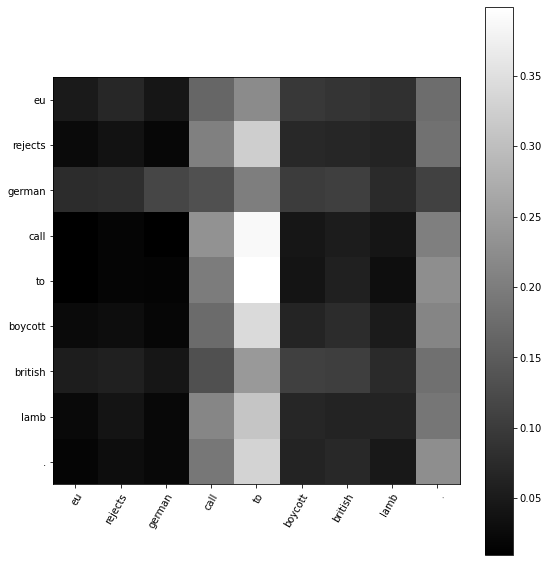

Pred. Tag	Actual Tag	Correct?	Token

O		B-ORG		✘		eu
O		O		✔		rejects
O		B-MISC		✘		german
O		O		✔		call
O		O		✔		to
O		O		✔		boycott
O		B-MISC		✘		british
O		O		✔		lamb
O		O		✔		.


In [8]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['tag']

print(sentence)
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG,
                                       CHAR)

print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

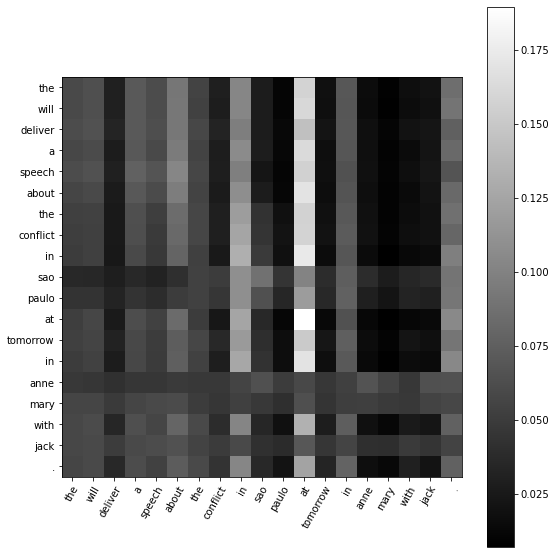

[]
Pred. Tag	Token

O		the
O		will
O		deliver
O		a
O		speech
O		about
O		the
O		conflict
O		in
O		sao
O		paulo
O		at
O		tomorrow
O		in
O		anne
O		mary
O		with
O		jack
O		.


In [9]:
sentence = 'The will deliver a speech about the conflict in Sao Paulo at tomorrow in Anne Mary with Jack.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG,
                                  CHAR)

print(unks)
print("Pred. Tag\tToken\n")


for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")